In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from functools import partial

import theano.tensor as tt
from theano.tensor import slinalg
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture
from pymc3 import DensityDist, CategoricalGibbsMetropolis, DataSampler
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import advi, adam, fit

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
weight_change = pd.read_csv('../data/clean/weight_change_year.csv', index_col=0)
weight_change.head()

,6389688,6463681,7311533,8548844,9285487,9729856,9852930,10964583,11158425,11167376,...,37415510,37656279,37820214,38027298,38098992,38167110,38187332,38524377,39248562,39855721
Days,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.000,0.00,0,NaN,0.00,0,0.0,0,...,0.0000,0.00,0,0,0.000,0.00,0.000000,0.000,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.98,NaN,4.7,NaN,...,1.1375,NaN,NaN,NaN,1.720,NaN,NaN,-0.170,NaN,NaN
2,NaN,NaN,NaN,-4.71,NaN,NaN,-3.63,NaN,12.7,NaN,...,2.4000,-0.32,NaN,NaN,1.175,-4.50,NaN,2.210,NaN,NaN
3,NaN,NaN,8.975,-7.43,NaN,NaN,-6.73,NaN,14.3,NaN,...,5.7100,NaN,NaN,NaN,2.040,-6.09,0.030000,6.175,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,-6.67,NaN,10.1,NaN,...,5.6200,NaN,NaN,NaN,4.260,-5.69,1.173333,9.720,NaN,NaN


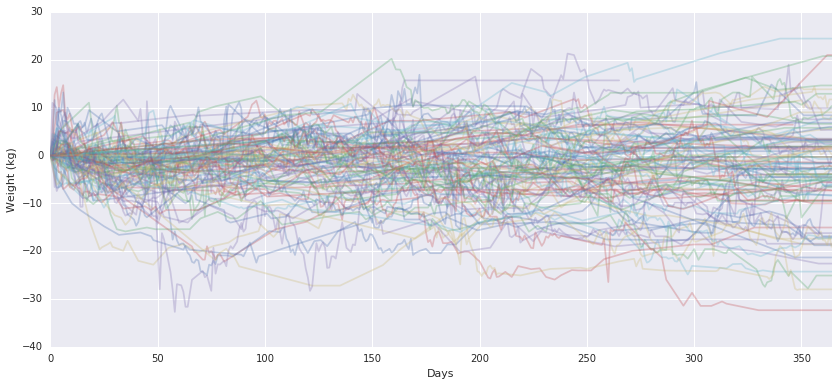

In [3]:
fig, axes = plt.subplots(figsize=(14,6))
(weight_change.interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

In [4]:
data_subset = weight_change.loc[:100]
data_subset = data_subset.loc[:, data_subset.notnull().sum() >= 10]

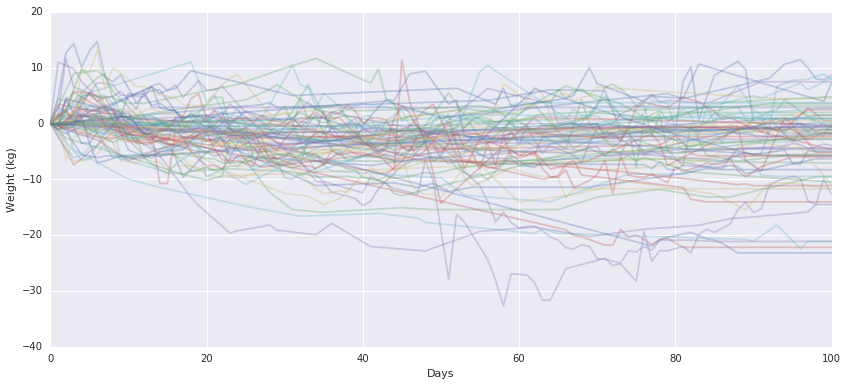

In [5]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

In [6]:
data_subset.shape

(101, 74)

Stick-breaking function for Dirichlet process

In [7]:
def stick_breaking(beta, complete=False):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    p = beta * portion_remaining
    if not complete:
        return p
    return tt.concatenate([p, [1-p.sum()]])

Maximum number of groups

In [10]:
K = 10
D, N = data_subset.shape

In [12]:
nknots = 10
knots = np.linspace(0, 100, nknots)

In [16]:
def interpolate(x0, y0, x):

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [19]:
with Model() as model:
    
    α = Gamma('α', 1., 1.)
    β = Beta('β', 1., α, shape=K)
    ω = Deterministic('ω', stick_breaking(β))
    
    z = Categorical('z', ω, shape=N)
    
    σ = HalfCauchy('σ', 5, shape=C)

    θ = tt.stack([GaussianRandomWalk('θ_%i' % i, sd=σ[i], shape=nknots) for i in range(C)])

    sd = HalfCauchy('sd', 5)
    
    for i in range(N):
        
        data = data_subset.iloc[:, i]
        observed = ~np.isnan(data)
        y = data[observed]
        x = np.where(observed)[0].reshape(-1,1)
        n = y.shape[0]
        
        Normal('trajectory_%i' % i, interpolate(knots, θ[z[i]], x), sd=sd, observed=y)



In [ ]:
with model:
    trace = sample(10000, init=None)


  2%|▏         | 228/10000 [12:55<7:52:26,  2.90s/it]

In [22]:
from pymc3 import traceplot, forestplot

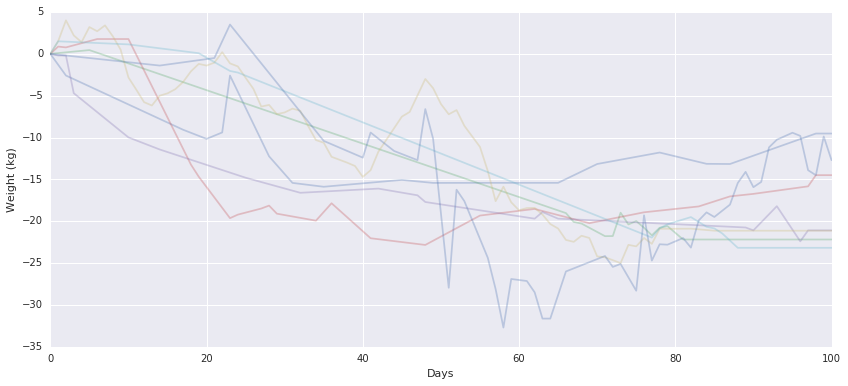

In [42]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==0].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

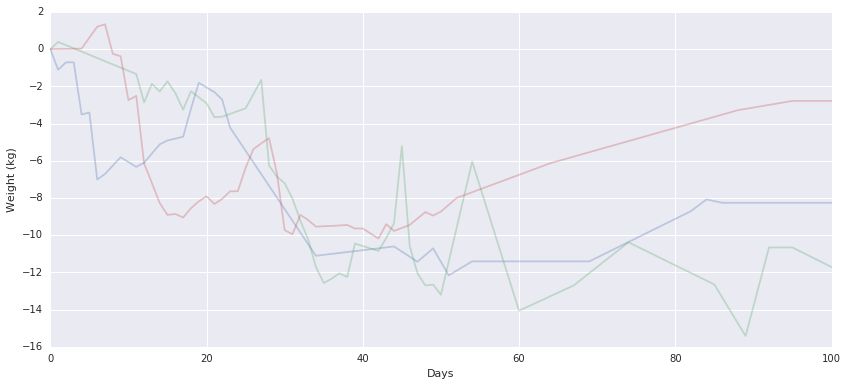

In [51]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==2].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

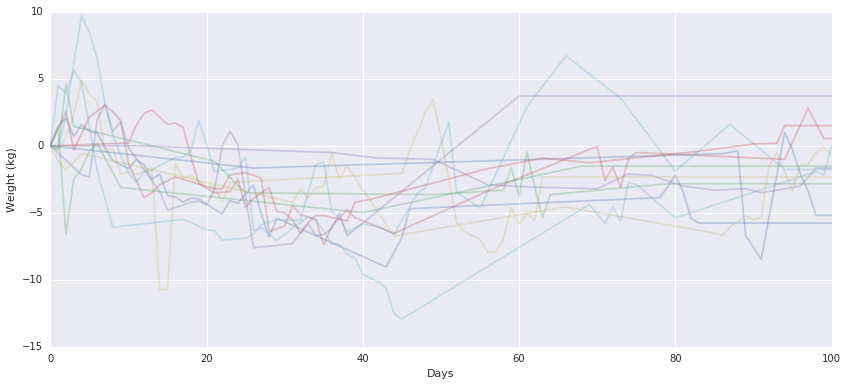

In [46]:
fig, axes = plt.subplots(figsize=(14,6))
(data_subset.iloc[:, np.median(trace['z'], 0)==5].interpolate(limit=100)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('Weight (kg)');

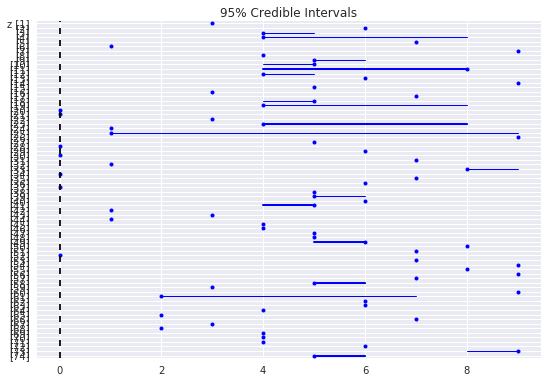

In [29]:
forestplot(trace, varnames=['z'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6b5fa748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0d616f77f0>]], dtype=object)

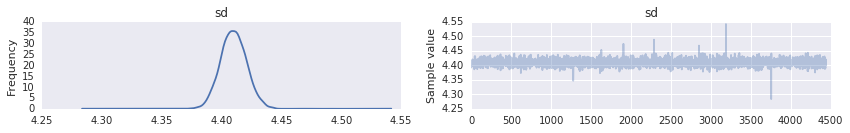

In [28]:
traceplot(trace[1000:], varnames=['sd'])